In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from earlystopping import EarlyStopping
%matplotlib inline
import pandas as pd
torch.version.cuda

'12.1'

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from self_transformers import Albumentations

In [4]:
data_transforms = {
    'train': transforms.Compose([
        Albumentations(),
        transforms.Resize((32, 256)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)
    ]),
    'val': transforms.Compose([
        transforms.Resize((32, 256)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)
        
    ]),
}

data_dir = '/data/yihwee/MinorTampering/3d_tampering/train_test_val_4'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=6) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [5]:
def create_model(model, weights = None):
    
    model = model(weights = weights) if weights != None else model()

    #Finetune Final few layers to adjust for tiny imagenet input
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())
    model.to(device)
    
    return model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Resnet18
album_rgb_resnet18 = create_model(resnet18, ResNet18_Weights.IMAGENET1K_V1)

#Following is the loss function and optimization used for baseline model
#Loss Function
loss_fn = nn.BCELoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(album_rgb_resnet18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/yihwee/anaconda3/envs/p311-cu121/lib/python3.11/site-packages/torch/cuda/__init__.py:126: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
album_rgb_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
test_losses = []
results = []
def test(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device, dtype=torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y.reshape(-1,1)).item()
            preds = [1 if i > 0.5 else 0 for i in pred]
            label = [1 if i > 0.5 else 0 for i in y.reshape(-1,1)]
            correct += sum([1 if preds[i] == label[i] else 0 for i in range(0, len(preds))])

    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)
            
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, model


In [9]:
train_losses = []
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device, dtype=torch.float)

        # Compute prediction error
        output = model(X)

        # Calculate loss
        loss = loss_fn(output, y.reshape(-1,1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

In [10]:
epochs = 5
early_stopping = EarlyStopping(patience=5, verbose=True, path='test')

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloaders['train'], album_rgb_resnet18, loss_fn, optimizer)
    test_loss, model_chkpnt = test(dataloaders['val'], album_rgb_resnet18, loss_fn)
    
    #Earlystopping
    early_stopping(test_loss, model_chkpnt) 
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
    # Release memory
    torch.cuda.empty_cache()
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.663953  [    0/16877]
loss: 0.261193  [ 3200/16877]
loss: 0.244756  [ 6400/16877]
loss: 0.225757  [ 9600/16877]
loss: 0.167743  [12800/16877]
loss: 0.151114  [16000/16877]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.084451 

Validation loss decreased (inf --> 0.084451).  Saving model ...

Epoch 2
-------------------------------
loss: 0.123514  [    0/16877]
loss: 0.395871  [ 3200/16877]
loss: 0.033564  [ 6400/16877]
loss: 0.042028  [ 9600/16877]
loss: 0.203128  [12800/16877]
loss: 0.034042  [16000/16877]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.066828 

Validation loss decreased (0.084451 --> 0.066828).  Saving model ...

Epoch 3
-------------------------------
loss: 0.031083  [    0/16877]
loss: 0.214073  [ 3200/16877]
loss: 0.025618  [ 6400/16877]
loss: 0.145475  [ 9600/16877]
loss: 0.194133  [12800/16877]
loss: 0.136224  [16000/16877]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.050110 

Validation loss decreased (0.066828 --> 0.050110)

In [11]:
# Load latest checkpoint
final_model = create_model(resnet18, ResNet18_Weights.IMAGENET1K_V1)
final_model.load_state_dict(torch.load('checkpoints/test_checkpoint.pt'))

<All keys matched successfully>

In [12]:
data_transforms2 = {
    'test': transforms.Compose([
        transforms.Resize((32, 256)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)
    ]),
}

image_datasets2 = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms2[x]) for x in ['test']}
dataset_sizes2 = {x: len(image_datasets2[x]) for x in ['test']}

In [13]:
predicted = []
actual = []

for i in range(0, dataset_sizes2['test']):
    x, y = image_datasets2['test'][i][0], image_datasets2['test'][i][1]
    x=x.to(device)
    final_model.eval()
    with torch.no_grad():
        pred = final_model(x.unsqueeze(0))
        predicted.append([1 if x > 0.8 else 0 for x in pred][0])
        actual.append(y)

In [14]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2294
           1       1.00      0.98      0.99      2281

    accuracy                           0.99      4575
   macro avg       0.99      0.99      0.99      4575
weighted avg       0.99      0.99      0.99      4575



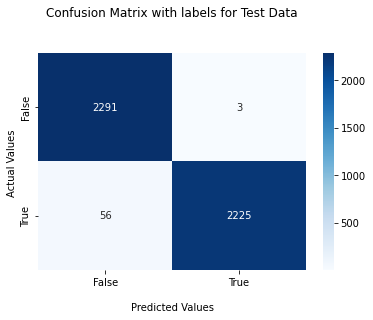

In [15]:
#Generate the confusion matrix for test set
cf_matrix = confusion_matrix(actual, predicted)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels for Test Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
torch.save(final_model, 'models/album_rgb_resnet18.pt')